In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans



In [2]:
data_dir = "cell_images"      
par_dir = os.path.join(data_dir, "Parasitized")
un_dir  = os.path.join(data_dir, "Uninfected")

img_size = (64, 64)           # RGB 64x64 -> 64*64*3 = 12288 features
max_per_class = 3000          

X = []
y = []

# Parasitized = 1
for i, fname in enumerate(os.listdir(par_dir)):
    if i >= max_per_class:
        break
    path = os.path.join(par_dir, fname)
    img = Image.open(path).convert("RGB")
    img = img.resize(img_size)
    arr = np.array(img, dtype="float32") / 255.0
    X.append(arr.flatten())
    y.append(1)

# Uninfected = 0
for i, fname in enumerate(os.listdir(un_dir)):
    if i >= max_per_class:
        break
    path = os.path.join(un_dir, fname)
    img = Image.open(path).convert("RGB")
    img = img.resize(img_size)
    arr = np.array(img, dtype="float32") / 255.0
    X.append(arr.flatten())
    y.append(0)

X = np.array(X)
y = np.array(y)

X.shape, y.shape


((6000, 12288), (6000,))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((4800, 12288), (1200, 12288))

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"],
    "class_weight": [None, "balanced"]
}

log_reg = LogisticRegression(max_iter=2000)
log_reg_cv = GridSearchCV(
    log_reg,
    param_grid_lr,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
log_reg_cv.fit(X_train_scaled, y_train)

print("Best params:", log_reg_cv.best_params_)
best_lr = log_reg_cv.best_estimator_


Best params: {'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}


In [5]:
y_pred_lr = best_lr.predict(X_test_scaled)
y_prob_lr = best_lr.predict_proba(X_test_scaled)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
cm_lr  = confusion_matrix(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

print("Logistic Regression accuracy :", acc_lr)
print("Logistic Regression AUC      :", auc_lr)
print("Confusion matrix:\n", cm_lr)
print("\nClassification report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression accuracy : 0.7016666666666667
Logistic Regression AUC      : 0.7630638888888889
Confusion matrix:
 [[428 172]
 [186 414]]

Classification report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.71       600
           1       0.71      0.69      0.70       600

    accuracy                           0.70      1200
   macro avg       0.70      0.70      0.70      1200
weighted avg       0.70      0.70      0.70      1200



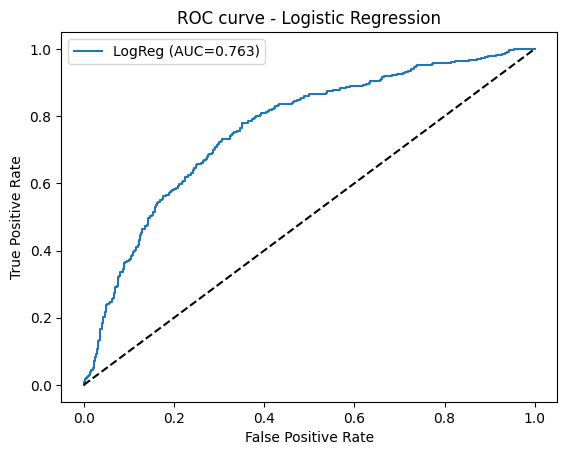

In [6]:
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr, tpr, label=f"LogReg (AUC={auc_lr:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Logistic Regression")
plt.legend()
plt.show()


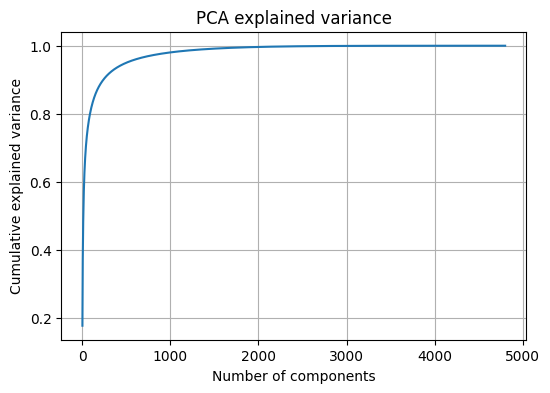

Cumulative variance with 100 components: 0.81586736


In [7]:
from sklearn.decomposition import PCA

pca_full = PCA().fit(X_train_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cum_var)+1), cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance")
plt.grid(True)
plt.show()

print("Cumulative variance with 100 components:", cum_var[99])


In [8]:
# PCA to reduce dimensionality before KMeans
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape

((4800, 100), (1200, 100))

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_sil = -1
best_seed = None

for seed in [0, 21, 42, 84, 123]:
    kmeans_tmp = KMeans(n_clusters=2, random_state=seed, n_init="auto")
    labels_tmp = kmeans_tmp.fit_predict(X_train_pca)
    sil = silhouette_score(X_train_pca, labels_tmp)
    print(f"Seed={seed}, silhouette={sil:.4f}")
    if sil > best_sil:
        best_sil = sil
        best_seed = seed

print("Best seed by silhouette:", best_seed, "score:", best_sil)


Seed=0, silhouette=0.2623
Seed=21, silhouette=0.2614
Seed=42, silhouette=0.2614
Seed=84, silhouette=0.2623
Seed=123, silhouette=0.2614
Best seed by silhouette: 84 score: 0.26233041286468506


In [10]:
kmeans = KMeans(n_clusters=2, random_state=best_seed, n_init="auto")
kmeans.fit(X_train_pca)

cluster_train = kmeans.predict(X_train_pca)

mapping = {}
for c in [0, 1]:
    mask = (cluster_train == c)
    majority_label = np.bincount(y_train[mask]).argmax()
    mapping[c] = majority_label
print("Cluster -> label mapping:", mapping)

cluster_test = kmeans.predict(X_test_pca)
y_pred_km = np.vectorize(mapping.get)(cluster_test)

acc_km = accuracy_score(y_test, y_pred_km)
cm_km  = confusion_matrix(y_test, y_pred_km)

print("KMeans (PCA=100, 2 clusters) accuracy :", acc_km)
print("Confusion matrix:\n", cm_km)


Cluster -> label mapping: {0: np.int64(0), 1: np.int64(1)}
KMeans (PCA=100, 2 clusters) accuracy : 0.5866666666666667
Confusion matrix:
 [[497 103]
 [393 207]]


In [11]:
cluster_test = kmeans.predict(X_test_pca)
y_pred_km = np.vectorize(mapping.get)(cluster_test)

acc_km = accuracy_score(y_test, y_pred_km)
cm_km  = confusion_matrix(y_test, y_pred_km)

print("KMeans (PCA=100, 2 clusters) accuracy :", acc_km)
print("Confusion matrix:\n", cm_km)

KMeans (PCA=100, 2 clusters) accuracy : 0.5866666666666667
Confusion matrix:
 [[497 103]
 [393 207]]


In [12]:
results_img = pd.DataFrame({
    "Model": ["Logistic Regression (tuned)", "KMeans + PCA(100)"],
    "Accuracy": [acc_lr, acc_km],
    "AUC": [auc_lr, np.nan]
})
results_img


,Model,Accuracy,AUC
0,Logistic Regression (tuned),0.701667,0.763064
1,KMeans + PCA(100),0.586667,NaN
